In [280]:
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
import math
from math import exp, factorial, sqrt, log, log10
import scipy.stats
import operator
import copy


In [281]:
slotTime = 1    # 예측 및, 바이어스 조정 시간 단위
timeLimit = 2   # 총 관찰 시간
xMin, xMax = 0, 1000   # x 범위
yMin, yMax = 0, 1000   # y 범위
msLam = 700e-6   #intensity (ie mean density) of the Poisson process
bsLam = 30e-6


per = 20   # low 그래프 %      # capacity 낮은 사용자들이 줄어들게끔하는 것이기 때문이 이쪽 비교하는 것이 옳다.

xDelta = xMax-xMin; yDelta = yMax-yMin;   # x, y 최대-최소
areaTotal = xDelta*yDelta;    # 넓이
msNum = 0     # MS 개수
bsNum = 0     # BS 개수
while msNum == 0: msNum = scipy.stats.poisson( msLam*areaTotal ).rvs()
while bsNum == 0: bsNum = scipy.stats.poisson( bsLam*areaTotal ).rvs()
print(f"MS 개수 : {msNum} / BS 개수 : {bsNum}")


MS 개수 : 682 / BS 개수 : 35


In [282]:
#--------------------- 유클리드 거리 ------------------------#
def distance(x1, y1, x2, y2):
  return (((x2 - x1) ** 2) + ((y2- y1) ** 2)) ** 0.5

#--------------------- dB 변환 ------------------------#
def dbmtomW(dbm):
    return (10 ** (dbm / 10))

def dbmtoW(dbm):
    return (10 ** (dbm / 10)) * 0.001

def dbtoW(db):
    return (10 ** (db / 10))    

def mWtodbm(mW):
    return (10 * math.log10(mW))

def Wtodbm(W):
    return(10 * math.log10(W / 0.001))

def Wtodb(W):
    return(10 * math.log10(W))


In [283]:
#  Capacity, SNR 계산에 필요한 파라미터
BW = 800                            # 대역폭은 800MHz
noise_spectral_density = -174       # 노이즈 대역 밀도  -174dBm/Hz

#--------------------- capacity 계산 ------------------------#
def Calculate_Capacity_ver1(bs, received_power, load):
  if bs < bsNum:
    SNR = received_power / ((dbmtoW(noise_spectral_density) * BW * 10e6))
    # 10e7이 맞도고 생각하는데 10e6으로 두셨네....잘 모르겠다...
    Capacity = (BW / load) * math.log(1 + SNR, 2)    # 단위는 Mbps
    return SNR, Capacity

def Calculate_Capacity_ver2(bs, received_power, bsload, msload):
  if bs < bsNum:
    SNR = received_power / ((dbmtoW(noise_spectral_density) * BW * 10e6))
    Capacity = (BW * msload / bsload) * math.log(1 + SNR, 2)    # 단위는 Mbps
    return SNR, Capacity




# Pathloss 식 계산에 필요한 파라미터 
alpa = 4
beta = 10.2
gamma = 2.36
dev = 7.6
carrier_freq = 28                   # 캐리어 주파수 28GHz

#--------------------- Pathloss 함수 ------------------------#
def pathloss(dist, deviation):
  return (10 * alpa * log10(dist)) + (beta) + (10 * gamma * log10(carrier_freq)) + deviation
  # np.random.normal(0, dev) 이것을 deviation으로 받는다.
  

#  received_power 계산에 필요한 파라미터
power_t = 30     # 기지국 송신 전력 30dBm
gain_ante = 18   # 안테나 이득 18dBi

#--------------------- Receive power 함수 ------------------------#
def receive_power(path):
  return dbmtoW(power_t + gain_ante - path)

In [284]:
class Data:
    
    def __init__(self):
        self.data = np.zeros(timeLimit) # 리스트 한 칸은 한 시간동안의 데이터라고 보면 됨
        self.usage = dict()

        # Mb per hour
        self.usage['web'] = 0.53e3
        self.usage['sns'] = 1.49e3
        self.usage['vid'] = 22.5e3
        self.usage['music'] = 2.86e3
        self.usage['vidChat'] = 10.2e3
        self.usage['game'] = 0.79e3


    def run(self):
        # 0 ~ timeLimit-1 까지 단말 하나가 어떤 사용을 하는지 랜덤 설정
        t = 0
        while True:
            tt = t + random.randint(0,int(timeLimit/4))
            if tt > timeLimit: tt = timeLimit
            u = random.choice(list(self.usage.keys()))

            for a in range(t, tt):
                self.data[a]=self.usage[u]
            
            t=tt
            if t==timeLimit: break
            else: continue



In [285]:
class MS:
    num = 0     # 클래스 변수, 모든 MS 객체가 공유하는 변수

    def __init__(self):
        self.num = MS.num  # 단말의 인덱스 번호
        self.x = xDelta*scipy.stats.uniform.rvs(0,1,(1))+xMin    # 단말의 x좌표
        self.y = yDelta*scipy.stats.uniform.rvs(0,1,(1))+yMin    # 단말의 y좌표
        self.d = Data()
        self.d.run()
        self.data = self.d.data       # 단말이 사용하는 데이터를 열거한 리스트
        self.near_bs = dict()       # 기지국들이랑 가까운 거리에 있는지 인덱스 번호랑 거리 표시
        self.connected_bs = 0       # 어느 기지국이랑 연결되어있는지 인덱스 번호 표시
        MS.num += 1

    def plot(self):
        plt.scatter(self.x, self.y, s=1, c="black", marker="s", label='UE' )    # 단말기는 검정색


class BS:
    num = 0     # 클래스 변수, 모든 BS 객체가 공유하는 변수

    def __init__(self):
        self.num = BS.num   # 기지국의 인덱스 번호
        self.x = xDelta*scipy.stats.uniform.rvs(0,1,(1))+xMin    # 기지국의 x좌표
        self.y = yDelta*scipy.stats.uniform.rvs(0,1,(1))+yMin    # 기지국의 y좌표
        self.connected_ms = []   # 현재 기지국에서 처리해주는 단말기 인덱스를 저장하는 곳
        self.count_ms = 0      # 연결된 단말기의 수
        self.future_data = np.zeros(slotTime)     # 미래의 특정 시간만큼, 자신이 처리할 데이터양 예측
        BS.num += 1

    def plot(self):
        plt.scatter(self.x, self.y, c="red", marker="^", label='Small Cell')   # BS는 빨간색

In [286]:
# 변수 이름에 숫자가 있을 것인데
# 1 들어가면 노말 용도
# 2 들어가면 밸런싱 용도

mslist1 = []
bslist1 = []
for a in range(msNum):
    mslist1.append(MS())
for a in range(bsNum):
    bslist1.append(BS())

#################################################
# 깊은 복사를 해줬어야 했는데 그걸 여태 안해줬었다.
mslist2 = copy.deepcopy(mslist1)
bslist2 = copy.deepcopy(bslist1)
# 밸런싱 환경과 노말 환경은 같다~~
#################################################

devi = np.random.normal(0, dev)

#######  노말일 때 처음 세팅
for a in mslist1:
    for b in bslist1:
        a.near_bs[b.num] = receive_power(pathloss(distance(a.x, a.y, b.x, b.y), devi))
    a.connected_bs = max(a.near_bs.items(), key = operator.itemgetter(1))[0]
    # 단말기가 이렇게 하면 최대 파워로 송신받고 있는 기지국 번호를 구하고, 초기 연결한다.
    bslist1[a.connected_bs].connected_ms.append(a.num)

for b in bslist1:
    b.count_ms = len(b.connected_ms)


#######  로드 밸런싱일 때 처음 세팅
for a in mslist2:
    for b in bslist2:
        a.near_bs[b.num] = receive_power(pathloss(distance(a.x, a.y, b.x, b.y), devi))
    a.connected_bs = max(a.near_bs.items(), key = operator.itemgetter(1))[0]
    # 단말기가 이렇게 하면 최대 파워로 송신받고 있는 기지국 번호를 구하고, 초기 연결한다.
    bslist2[a.connected_bs].connected_ms.append(a.num)

for b in bslist2:
    b.count_ms = len(b.connected_ms)


"""
어차피 로드밸런싱일 때나 노말일 때 맨 처음 연결은 똑같이 하기 때문에 이래도 되지 않을까 싶다.
mslist2 = copy.deepcopy(mslist1)
bslist2 = copy.deepcopy(bslist1)
"""

'\n어차피 로드밸런싱일 때나 노말일 때 맨 처음 연결은 똑같이 하기 때문에 이래도 되지 않을까 싶다.\nmslist2 = copy.deepcopy(mslist1)\nbslist2 = copy.deepcopy(bslist1)\n'

[  1  ]
snr
2.6320567064579823 %
capacity
24.142541730259296 %
[  2  ]
snr
0.9515672137943694 %
capacity
1.2463230627231063 %
[  3  ]
snr
8.121790069302644 %
capacity
36.30542724112893 %
[  4  ]
snr
3.5303710945097406 %
capacity
1.5284865762366167 %
[  5  ]
snr
2.179716586060268 %
capacity
24.101693176116086 %
[  6  ]
snr
1.0524607000969046 %
capacity
3.7630737390778046 %
[  7  ]
snr
5.283999002920978 %
capacity
30.645534103683037 %
[  8  ]
snr
0.8786721184512893 %
capacity
3.253639208781904 %
[  9  ]
snr
2.7011949270216573 %
capacity
23.84441536735233 %
[  10  ]
snr
1.1351858584053565 %
capacity
3.7412723010439914 %
[  11  ]
snr
2.8853950299516784 %
capacity
23.86547746643929 %
[  12  ]
snr
0.6532028678551322 %
capacity
3.5086608032390463 %
[  13  ]
snr
3.528486526291535 %
capacity
27.2865198724967 %
[  14  ]
snr
1.351464258502295 %
capacity
1.3876177259999056 %
[  15  ]
snr
5.73983161642264 %
capacity
30.571585683549944 %
[  16  ]
snr
1.4227168011192304 %
capacity
3.465499529873359 %

C:\Users\cho\AppData\Local\Temp\ipykernel_536\2258302929.py:210: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(slot, figsize = (25, 5))


[  22  ]
snr
1.0413775072588438 %
capacity
5.2918092592379775 %
[  23  ]
snr
3.407962093672809 %
capacity
27.519191390771493 %
[  24  ]
snr
1.0797654877322864 %
capacity
3.919702061782593 %
[  25  ]
snr
5.369166759715948 %
capacity
30.810919894145112 %
[  26  ]
snr
0.03610234153852422 %
capacity
-3.912711976904194 %
[  27  ]
snr
6.040286225019587 %
capacity
30.805375226698374 %
[  28  ]
snr
-0.3112868690414592 %
capacity
-2.864031810795132 %
[  29  ]
snr
3.6719776662826282 %
capacity
28.331806704402947 %
[  30  ]
snr
1.1102866023064846 %
capacity
3.747900020582447 %
[  31  ]
snr
2.788431570299184 %
capacity
23.85395264592589 %
[  32  ]
snr
0.997358629428547 %
capacity
4.757835526607733 %
[  33  ]
snr
1.80729932298497 %
capacity
23.791295190419916 %
[  34  ]
snr
1.1089970298470733 %
capacity
5.189784962650671 %
[  35  ]
snr
3.747612898245921 %
capacity
28.053631775471562 %
[  36  ]
snr
1.2083524699963755 %
capacity
3.5072391178300086 %
[  37  ]
snr
2.362522140217999 %
capacity
24.815750

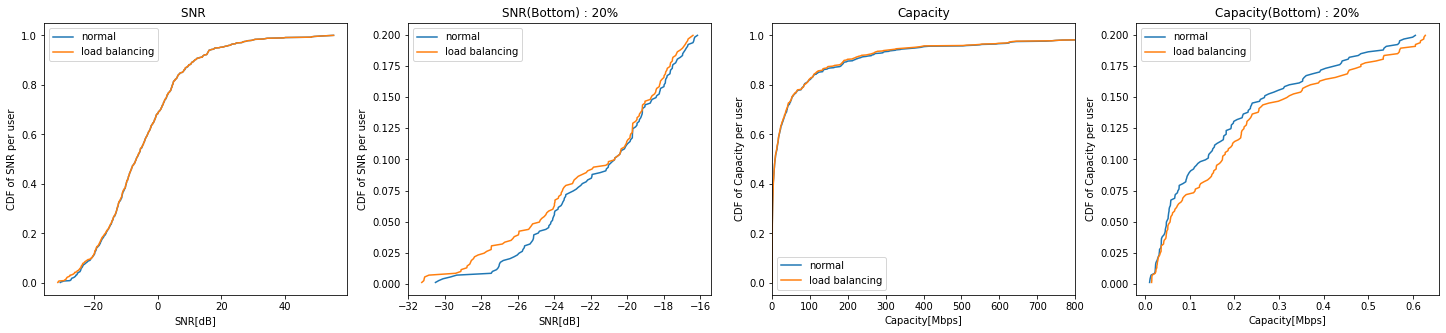

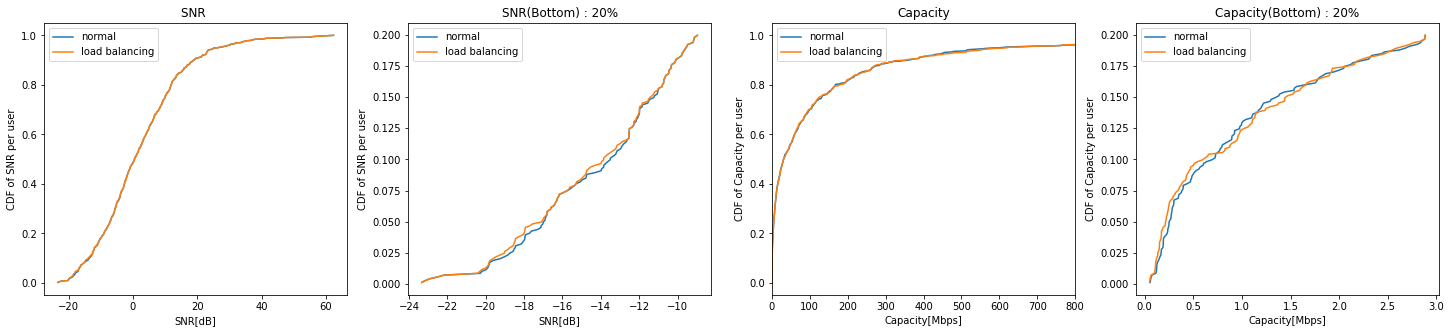

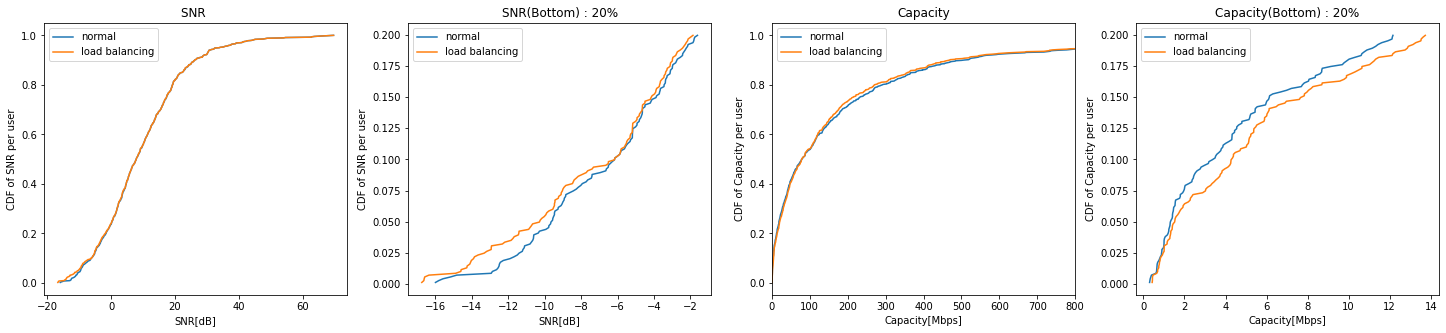

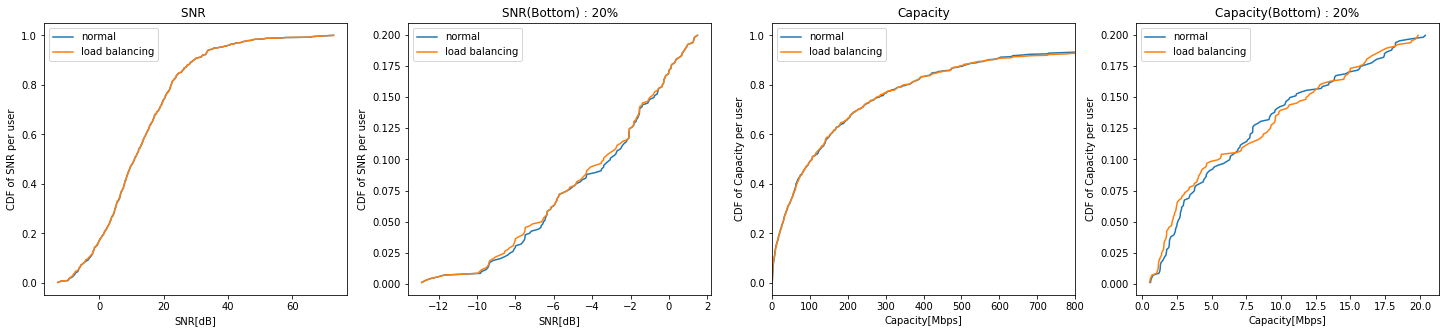

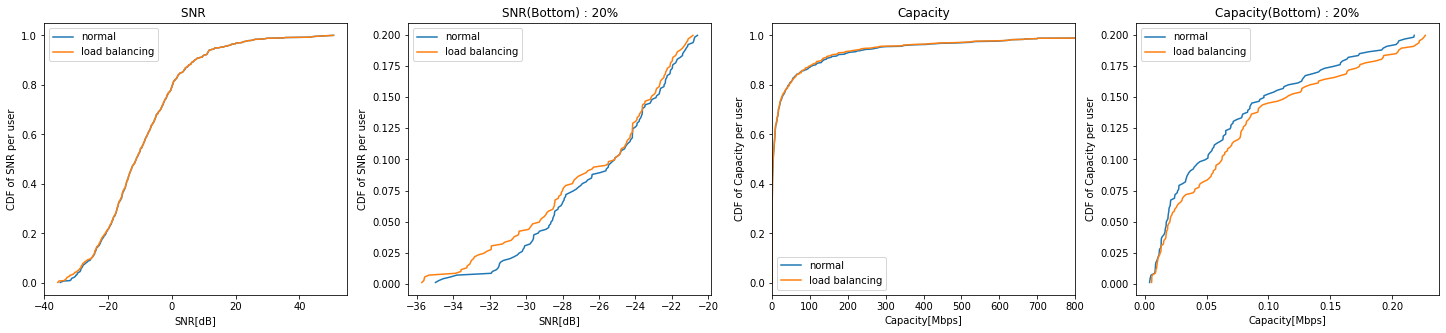

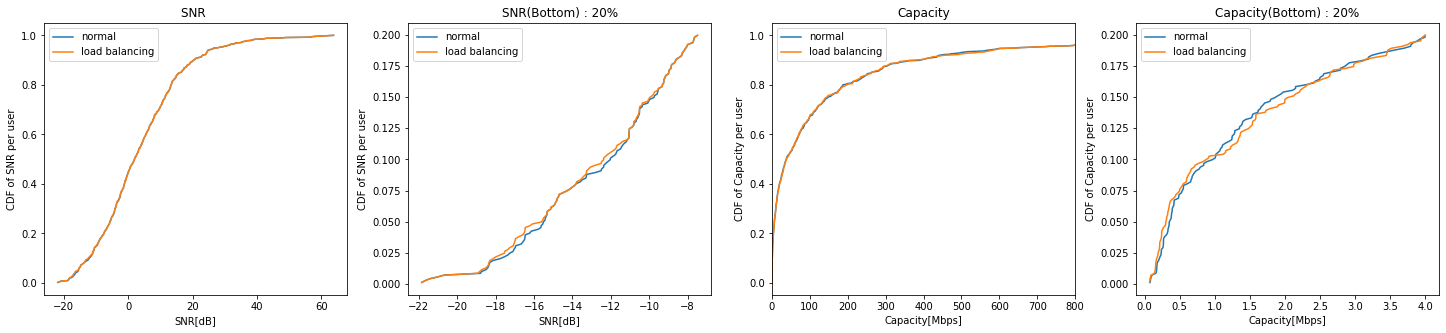

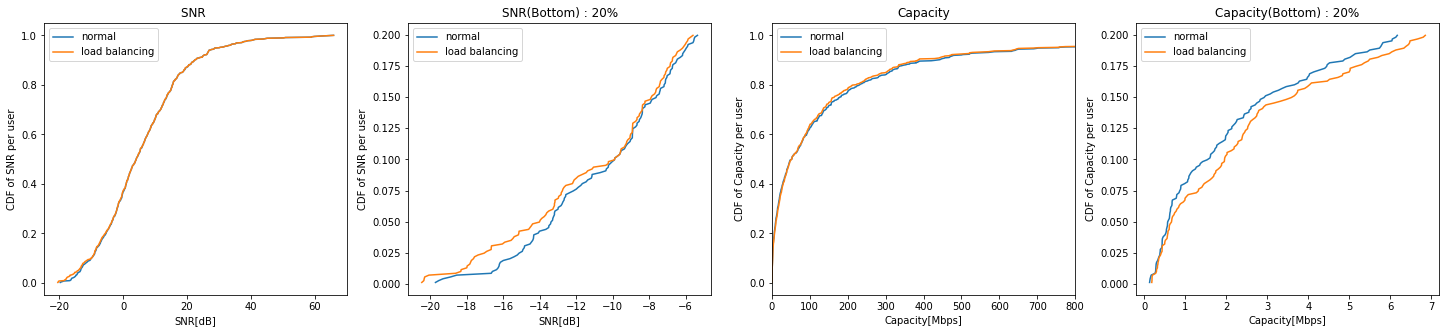

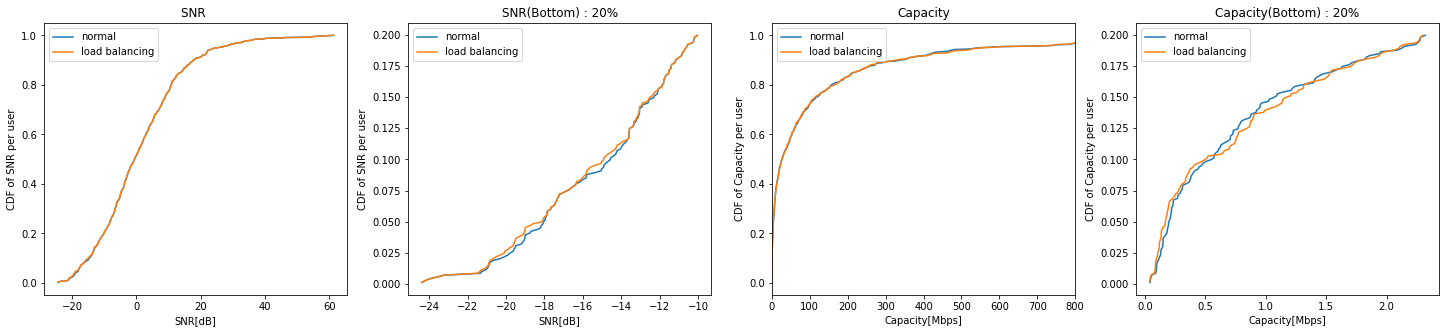

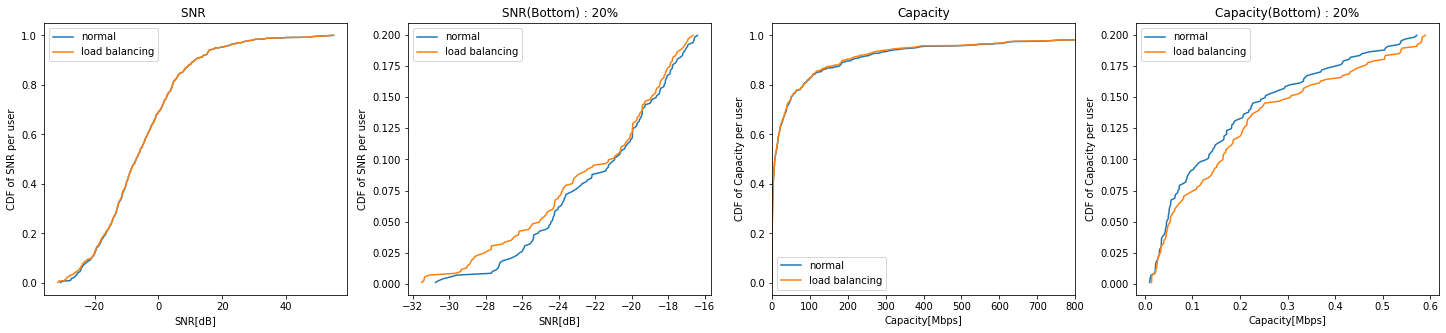

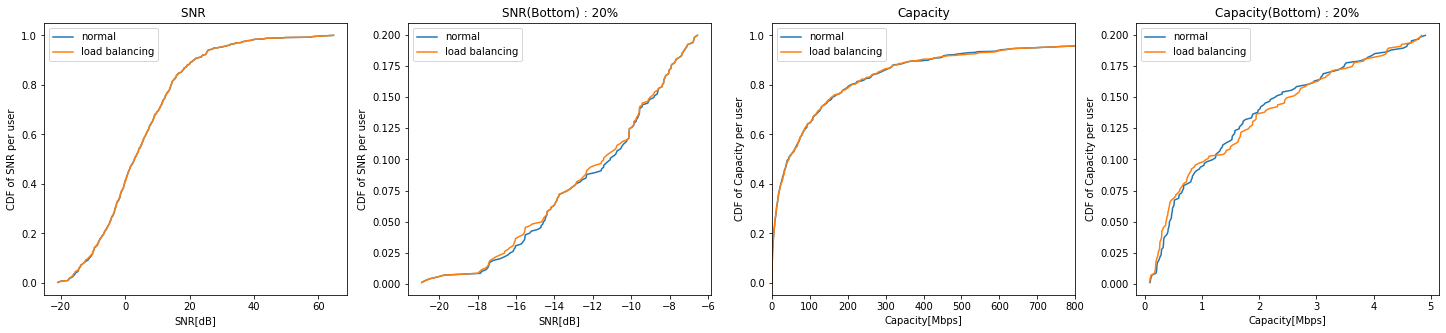

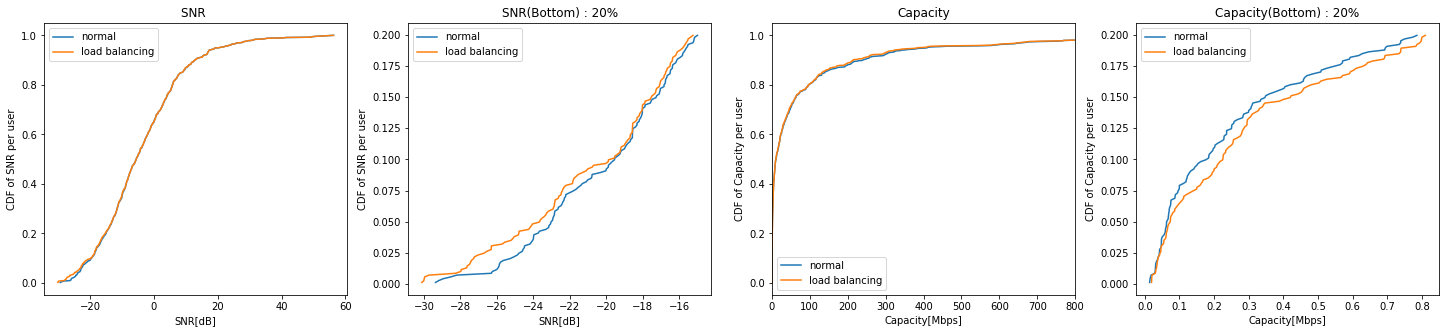

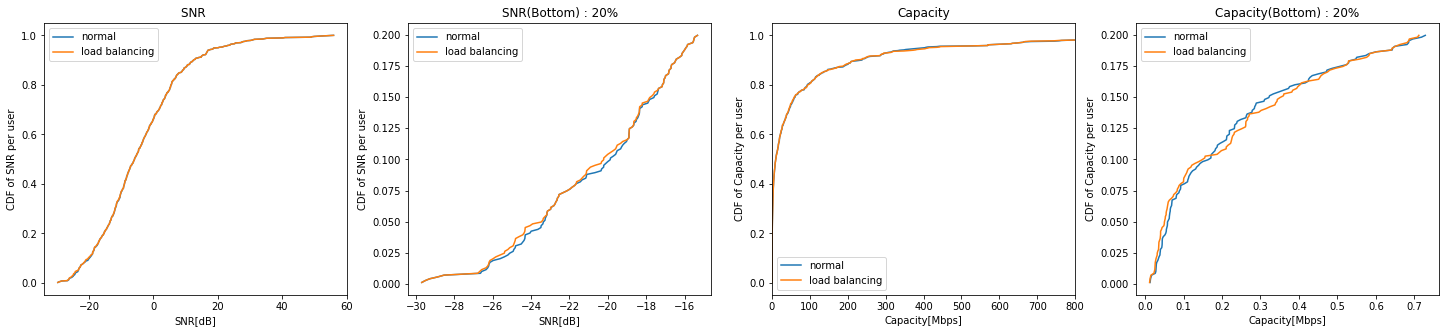

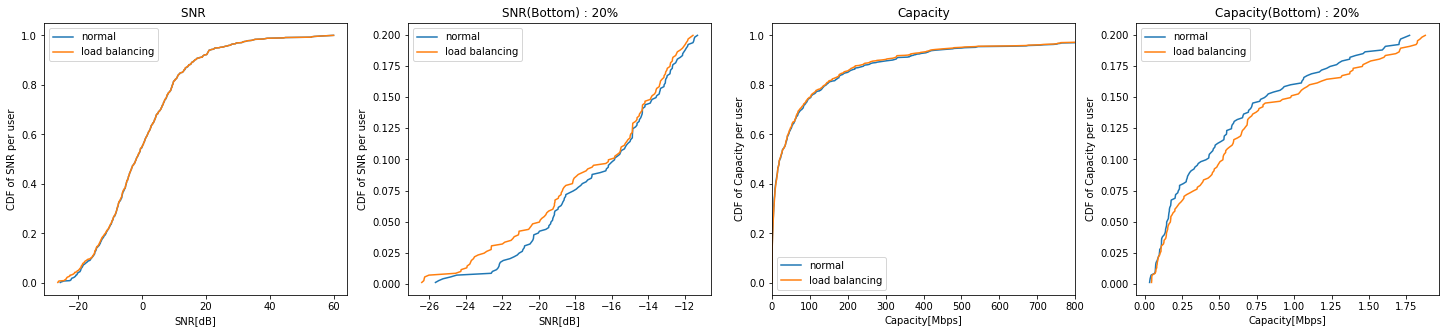

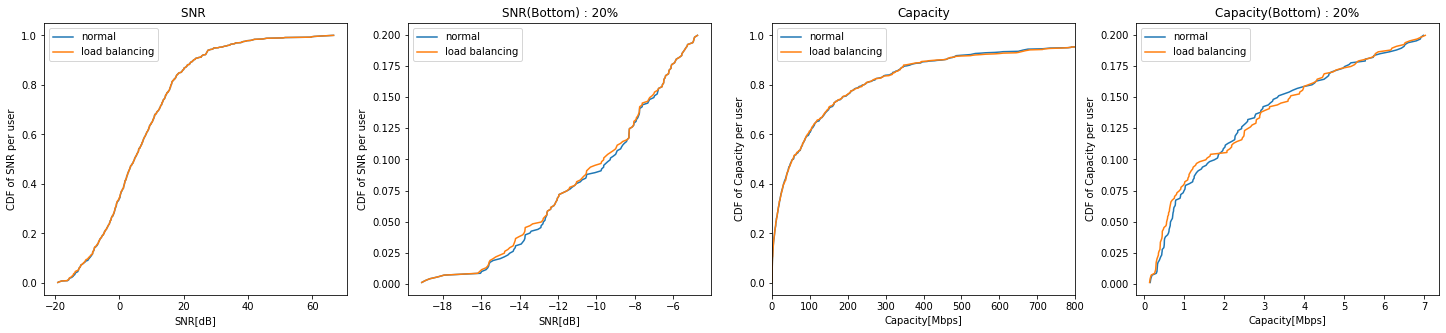

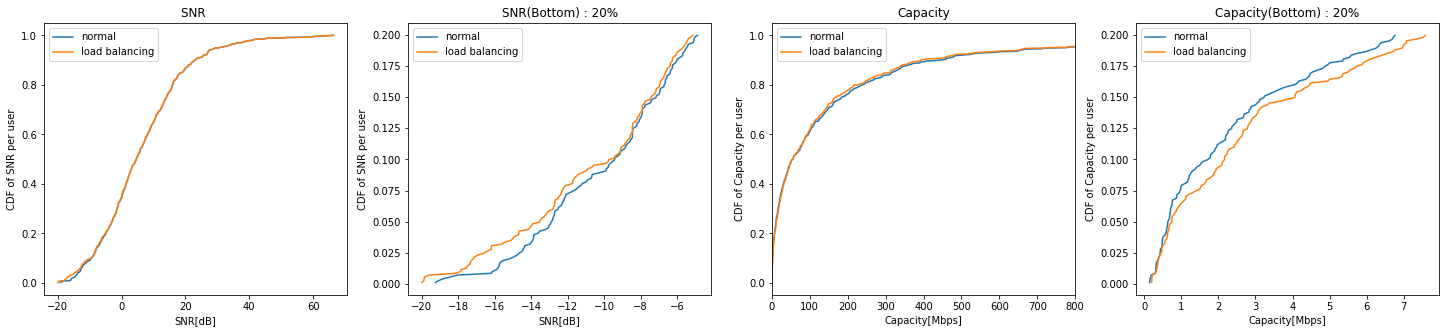

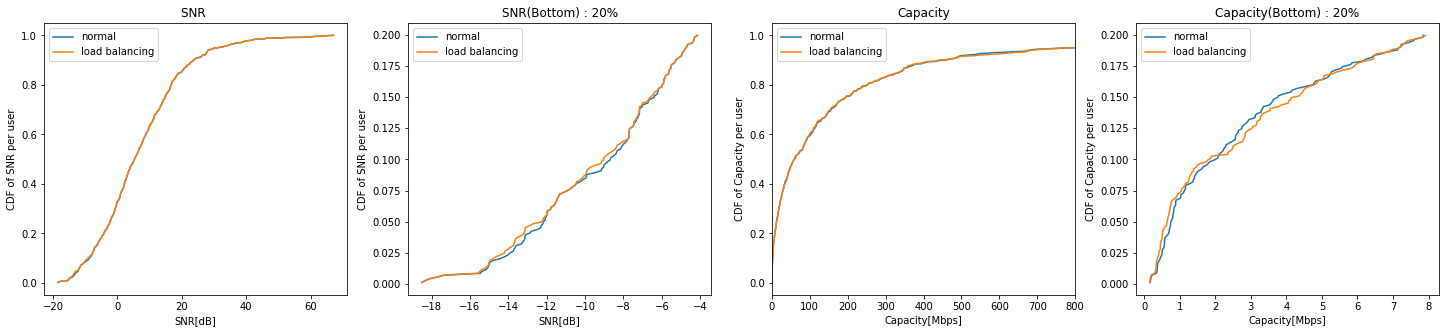

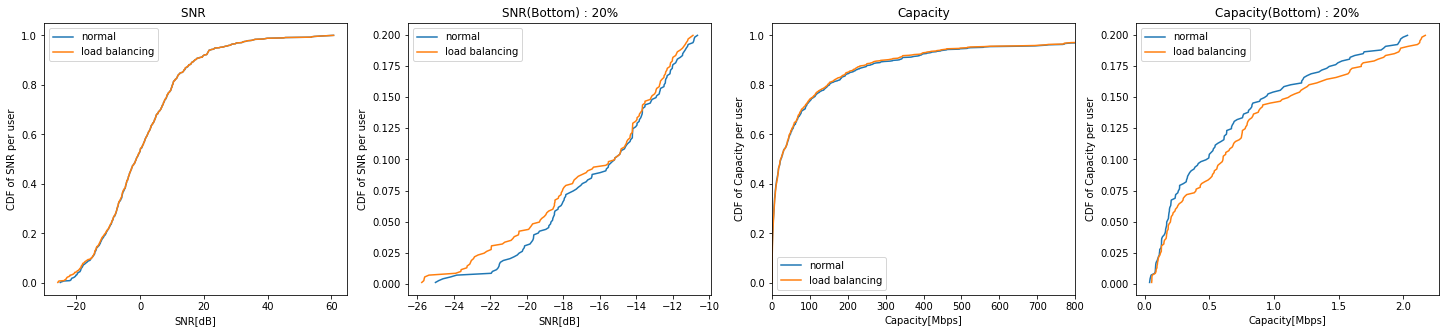

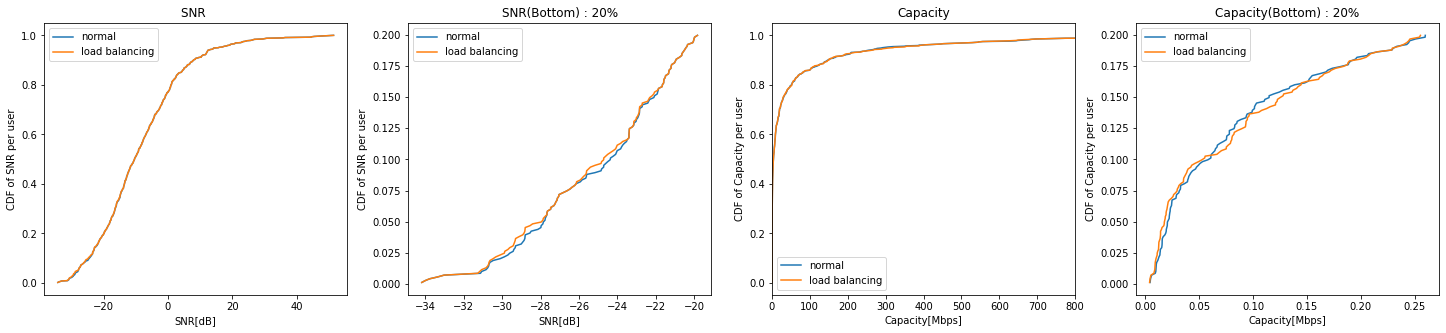

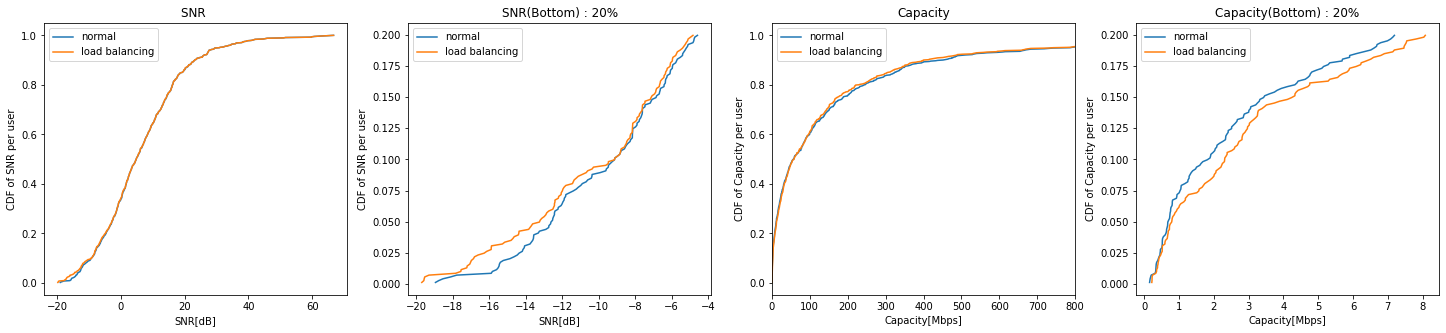

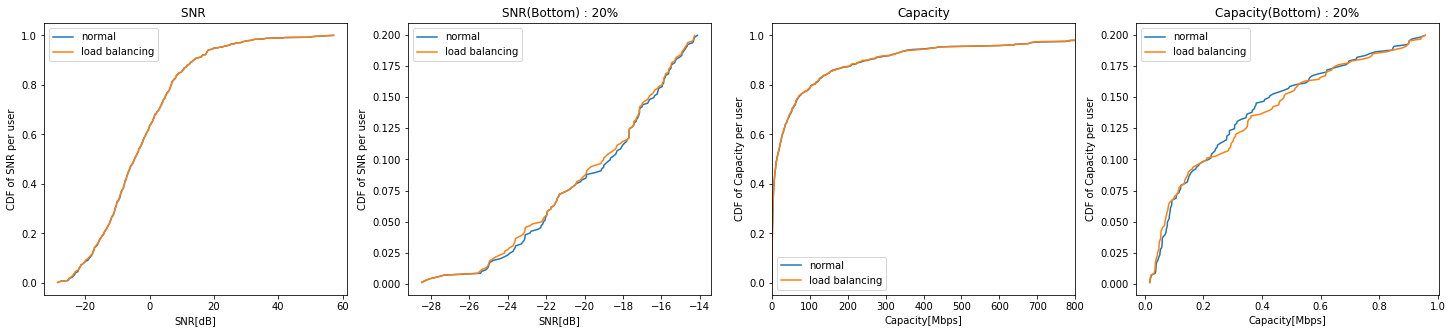

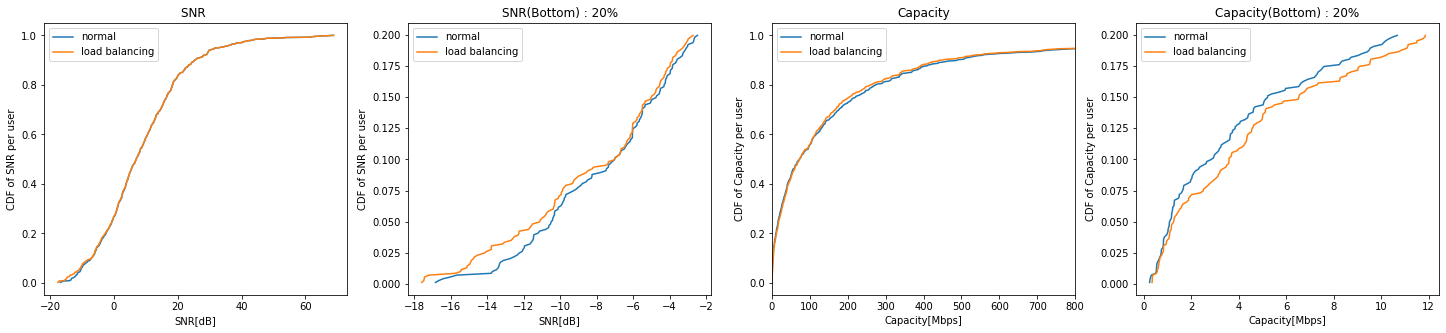

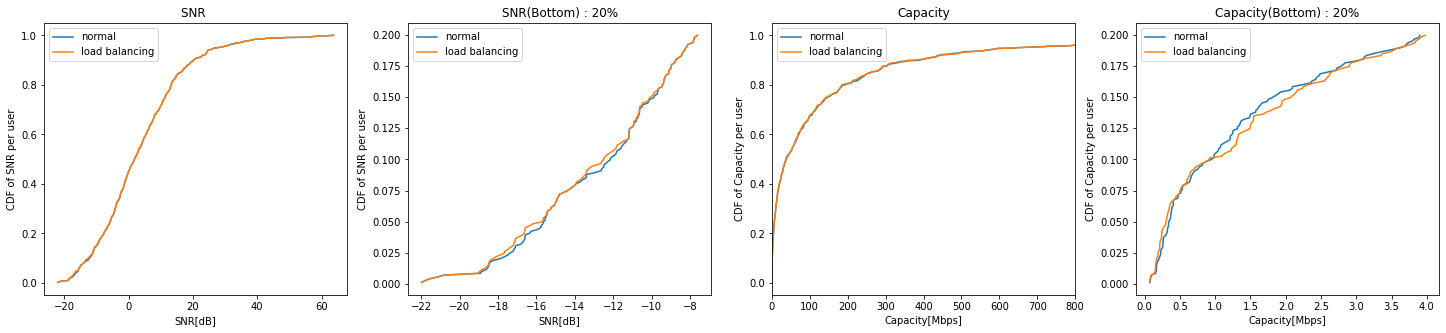

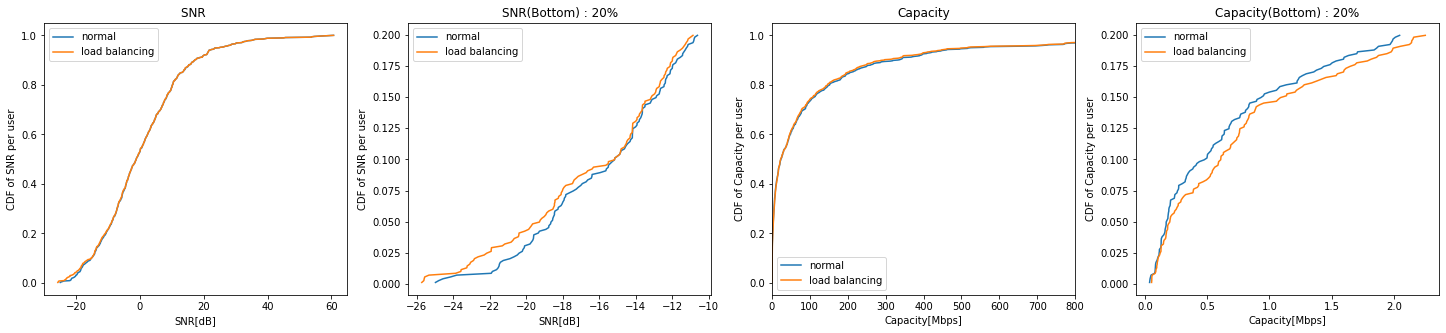

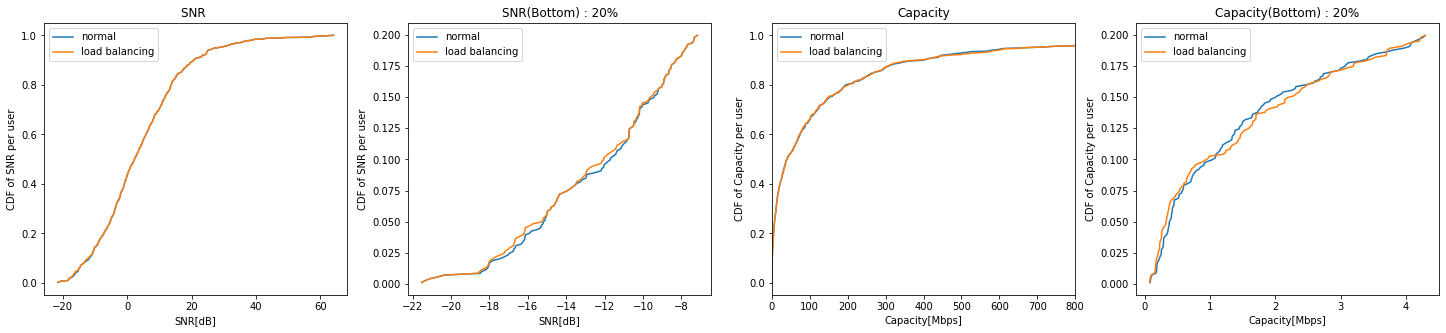

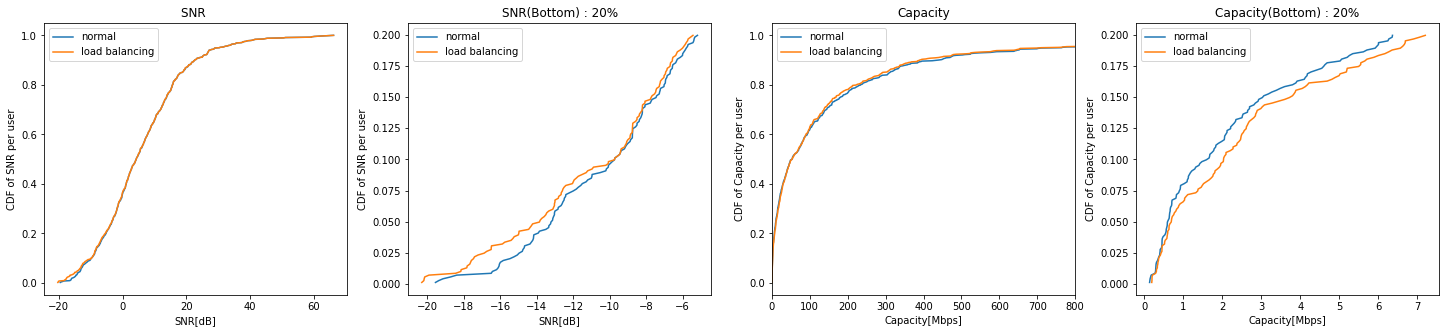

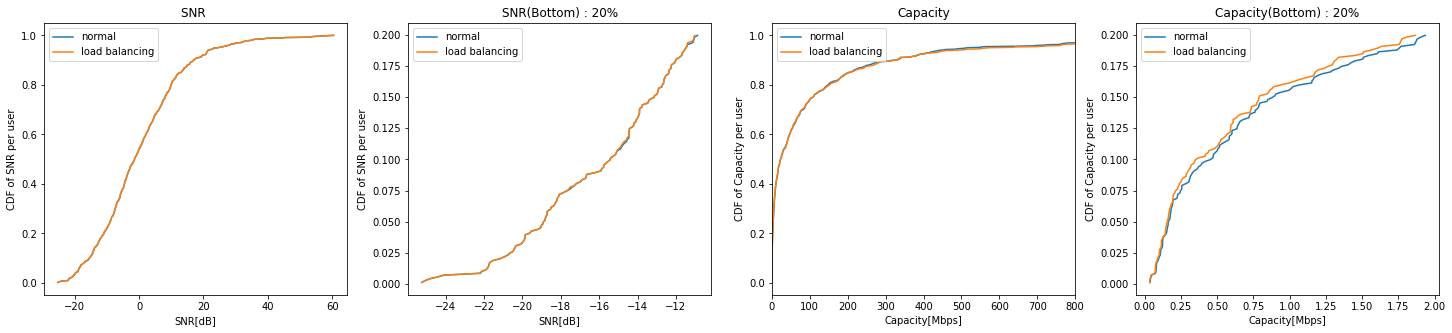

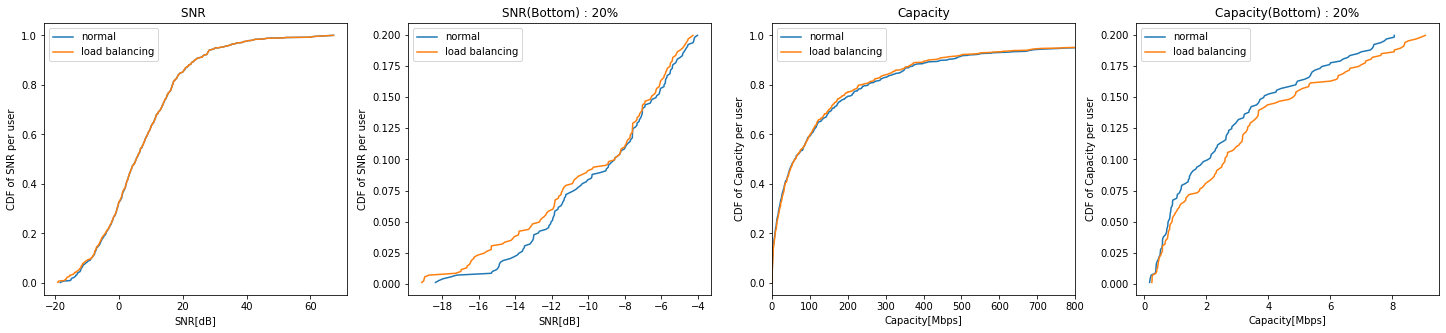

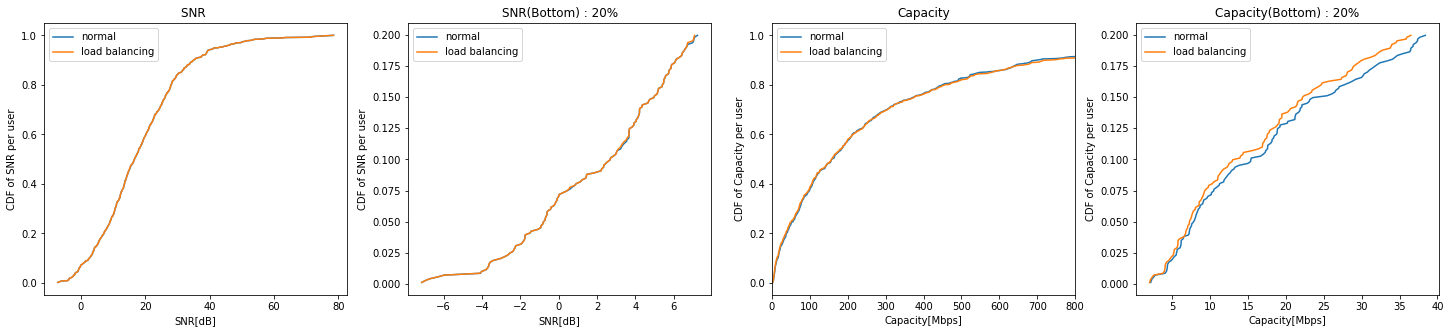

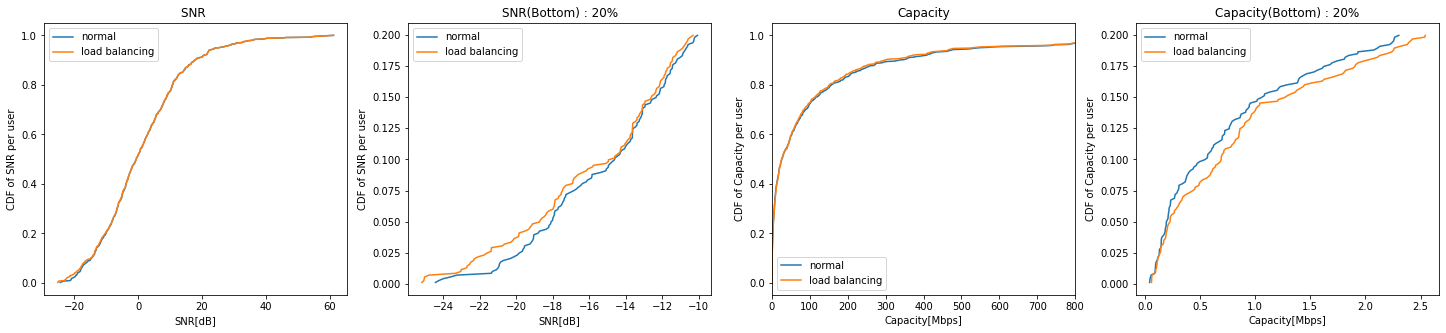

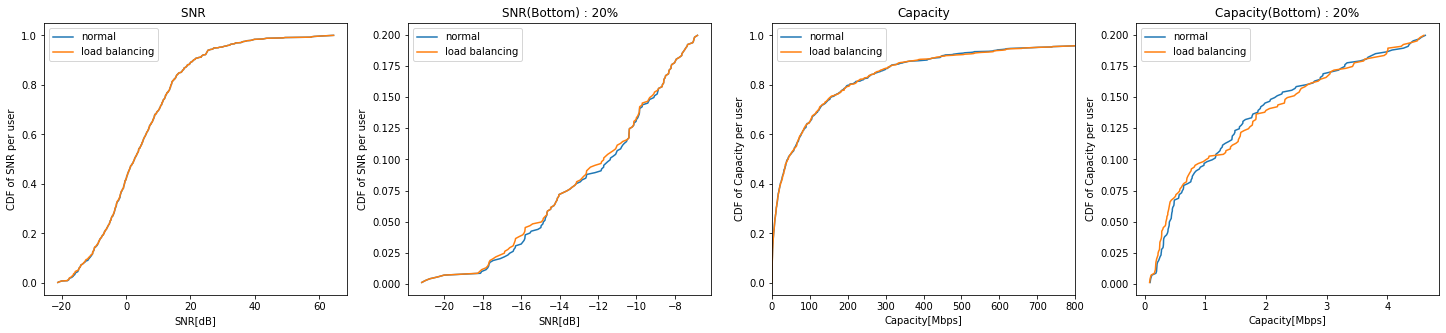

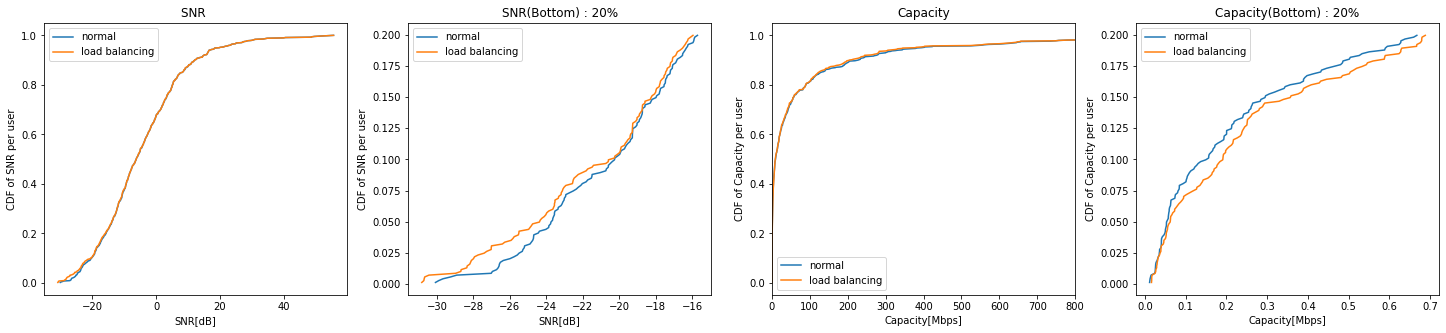

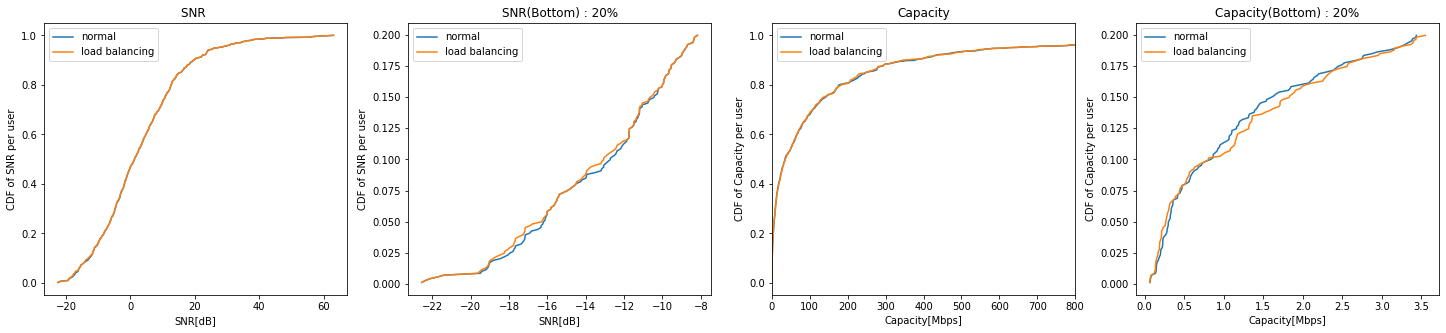

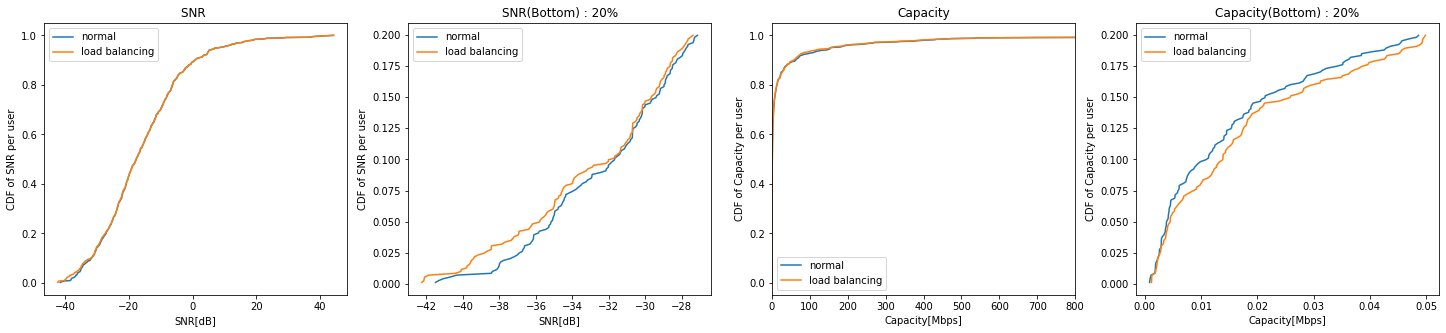

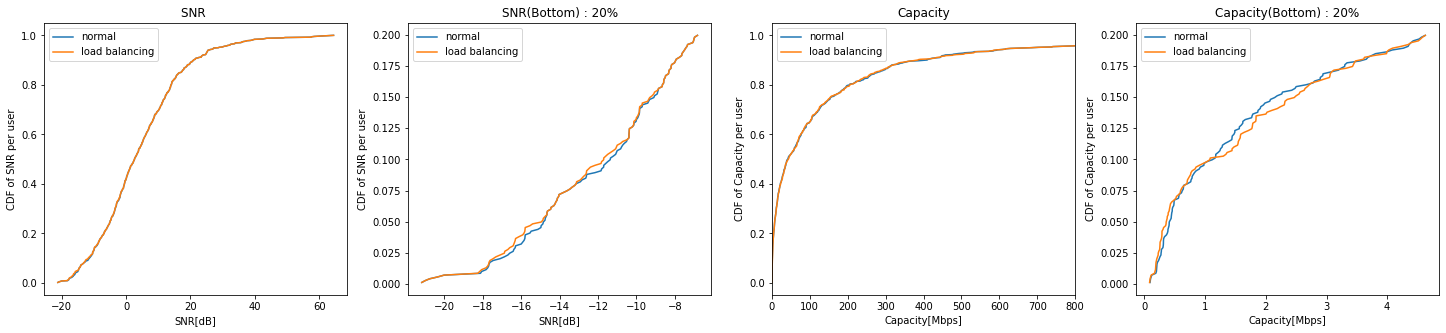

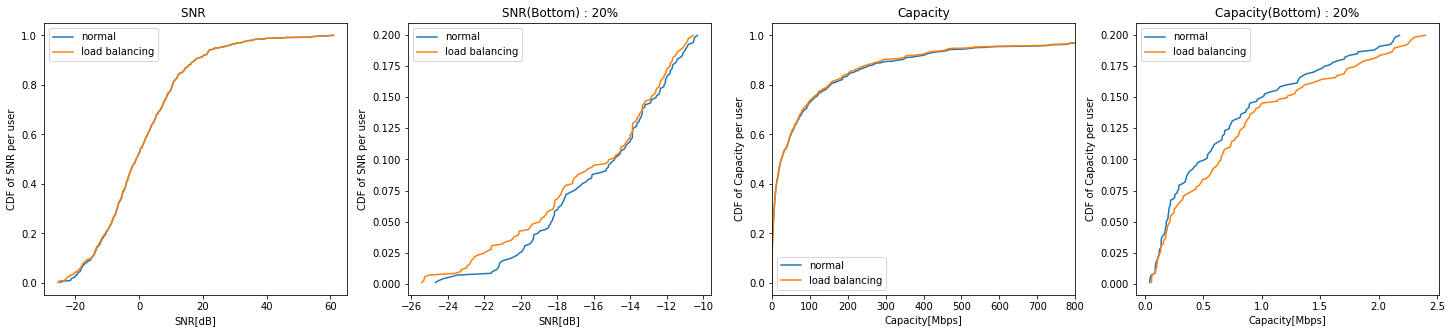

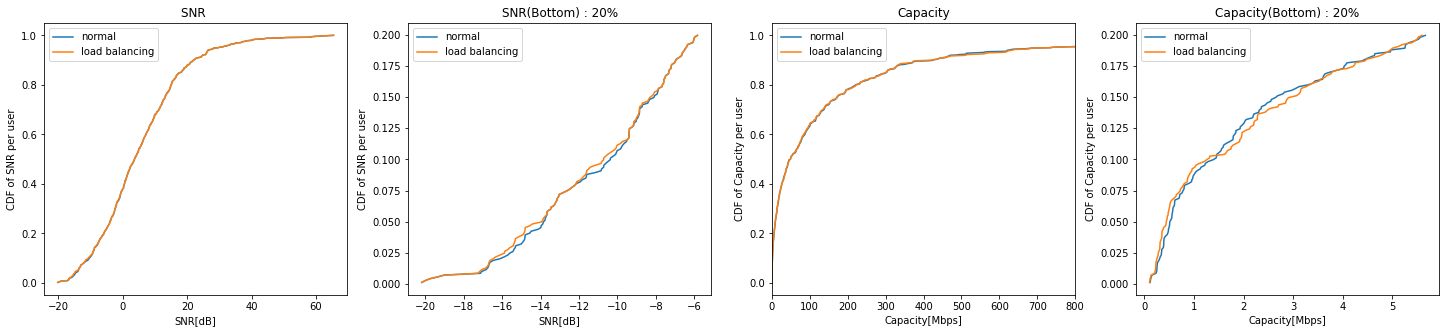

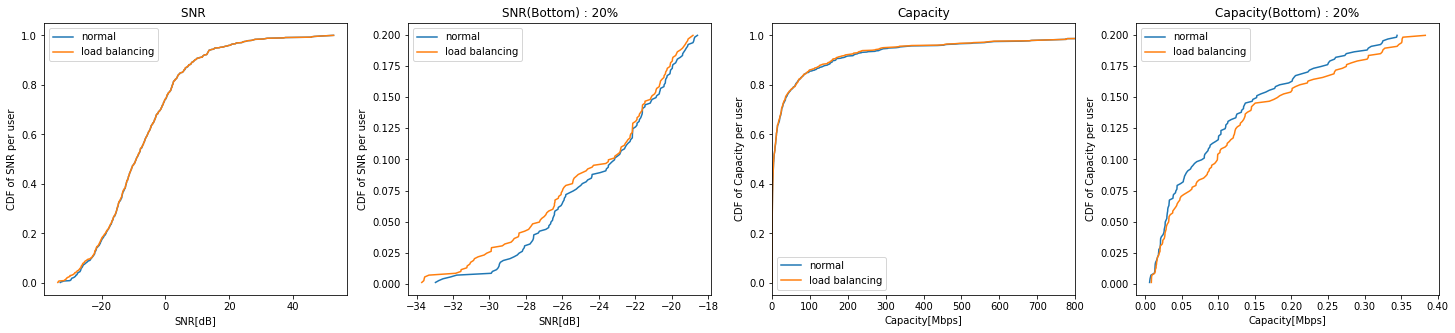

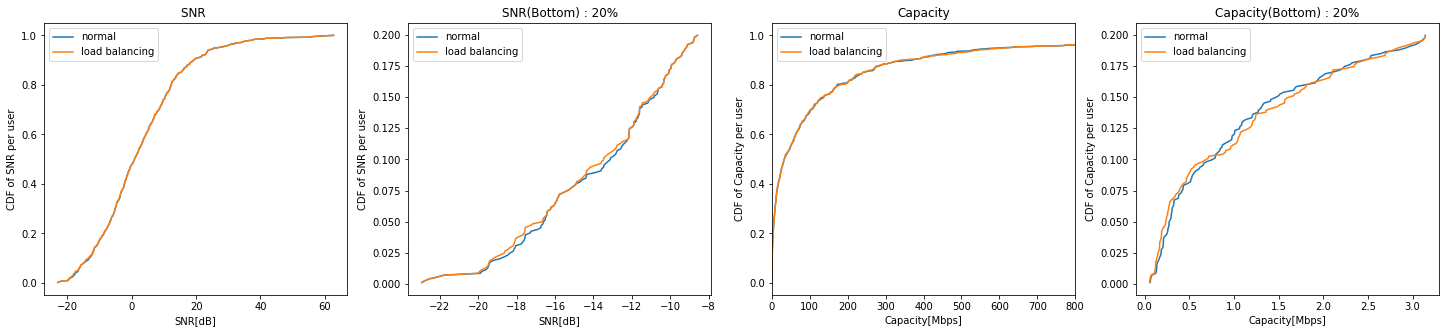

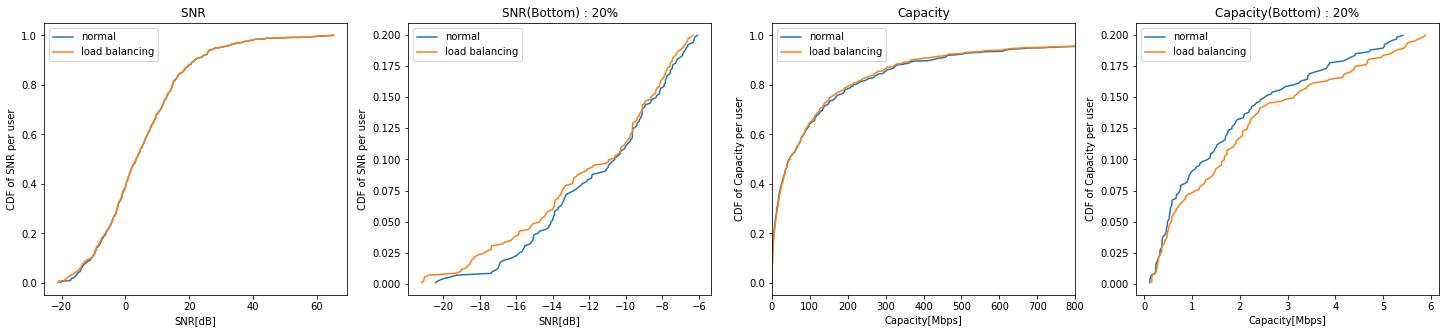

In [287]:
t = slotTime     #시간 흐름. 맨 처음엔 예측 없이 연결했고, 한 주기 뒤의 것부터 예측 시작
slot = 1
sslot = 1001


# 이제부터는 시간의 흐름 속에 빠져든다.
# 노말일 경우에는 단말기와 기지국 연결이 변하는 것이 없지만,
# 밸런싱일 경우에는 매 주기마다 바이어스 값 조절해서 단말기와 기지국 연결이 달라질 수 있다.
while t <= timeLimit - slotTime:
    devi = np.random.normal(0, dev)
    tt = t + slotTime

    snr1 = []
    capacity1 = []
 ### 노말의 경우 연결은 똑같기 때문에 바로 snr, capacity 계산
    for a in mslist1:
        b = bslist1[a.connected_bs]
        S1, C1 = Calculate_Capacity_ver1(b.num, receive_power(pathloss(distance(a.x, a.y, b.x, b.y), devi)), b.count_ms)
        # 연결된 것을 기반으로 실제 수신파워를 적용한 것임
        snr1.append(S1)
        capacity1.append(C1)


 ### 로드밸련싱의 경우 연결(바이어스 계산 시작)
    total = np.zeros(bsNum)

    for a in bslist2:
        a.future_data = np.zeros(slotTime)
        if len(a.connected_ms) == 0: 
            a.future_data = np.zeros(slotTime)
        else:
            for b in a.connected_ms:
                c = mslist2[b].data[t:tt]     # t부터 tt-1까지 성분들
                a.future_data += c
            
        total[a.num] = sum(a.future_data)

 # 여기는 바이어스 계산, 알고리즘이죠. (지금은 가벼운 생각으로 구성한 것이지만...)
    
    kk = sum(total)
    total /= kk
    total = 1 - total
    total *= 2
    for a in range(len(total)):
        if total[a] == total.min():
            total[a] = 1
    bias = total      # 각 기지국에 적용할 bias 값
    """          
    bunmo = 0
    bias = np.zeros(bsNum)
    zero_replace = 0.1 #0 대체 값
    for i in range(bsNum):
        if total[i]==0:
            bunmo += 1/zero_replace
        else:
            bunmo += 1/total[i]
    for i in range(bsNum):
        if total[i] == 0:
            a = bsNum*(1/zero_replace)/bunmo
        else:
            a = bsNum*(1/total[i])/bunmo
        if a < 1:
            bias[i] = 1
        else:
            bias[i] = a
    """
            
 # (bias 적용해 새롭게 연결)
    # 각 기지국에 연결된 단말기 리스트를 다시 설정하기 위한 초기화
    for a in bslist2:
        a.connected_ms.clear()

    for a in mslist2:
        for b in bslist2:
            a.near_bs[b.num] = bias[b.num] * receive_power(pathloss(distance(a.x, a.y, b.x, b.y), devi))
        a.connected_bs = max(a.near_bs.items(), key = operator.itemgetter(1))[0]
        # 단말기가 이렇게 하면 바이어스 적용한 최대 파워로 송신받고 있는 기지국 번호를 구하고, 연결한다.
        # 연결을 위한 수신 파워 측정시에만 바이어스 값을 적용한 것이다.
        bslist2[a.connected_bs].connected_ms.append(a.num)

    for b in bslist2:
        b.count_ms = len(b.connected_ms)


    # 연결했으니 이때의 SNR, Capacity 를 확인해야지
    snr2 = []
    capacity2 = []
    for a in mslist2:
        b = bslist2[a.connected_bs]
        S2, C2 = Calculate_Capacity_ver1(b.num, receive_power(pathloss(distance(a.x, a.y, b.x, b.y), devi)), b.count_ms)
        # 연결된 것을 기반으로 실제 수신파워를 적용한 것임
        snr2.append(S2)
        capacity2.append(C2)



 ######## 그림 그려야지
    snr1_db = np.zeros(msNum)
    snr2_db = np.zeros(msNum)
    for i in range(msNum):
        snr1_db[i] = Wtodb(snr1[i])
        snr2_db[i] = Wtodb(snr2[i])


    snr1_db_dic = {index : item for index, item in enumerate(snr1_db)}
    capacity1_dic = {index : item for index, item in enumerate(capacity1)}
    snr2_db_dic = {index : item for index, item in enumerate(snr2_db)}
    capacity2_dic = {index : item for index, item in enumerate(capacity2)}

    s1 = dict(sorted(snr1_db_dic.items(), key = lambda item:item[1], reverse= False))
    c1 = dict(sorted(capacity1_dic.items(), key = lambda item:item[1], reverse= False))
    s2 = dict(sorted(snr2_db_dic.items(), key = lambda item:item[1], reverse= False))
    c2 = dict(sorted(capacity2_dic.items(), key = lambda item:item[1], reverse= False))

    ss1 = dict(sorted(snr1_db_dic.items(), key = lambda item:item[1], reverse= True))
    cc1 = dict(sorted(capacity1_dic.items(), key = lambda item:item[1], reverse= True))
    ss2 = dict(sorted(snr2_db_dic.items(), key = lambda item:item[1], reverse= True))
    cc2 = dict(sorted(capacity2_dic.items(), key = lambda item:item[1], reverse= True))

    count = 0
    le = int(len(s1) * 0.2)
    scount = 0

    x1 = 0
    y1 = 0
    print("[  {}  ]".format(t))
    print("snr")
    for a in s1.keys():
        if count == le:
            break
        else:
            #print("mobile station number : {}, normal snr : {}, balancing snr : {}".format(a, s1[a], s2[a]))
            x1 += s1[a]
            y1 += s2[a]
            if s2[a] >= s1[a]: scount += 1
        count += 1
    
    print((y1-x1)/x1*100, "%")
    #print(" 하위 20퍼센트 단말 {}개 중에서 snr 향상된 단말의 갯수 : {}".format(le, scount))

    count = 0    
    le = int(len(c1) * 0.2)
    ccount = 0
    xx1 = 0
    yy1 = 0
    print("capacity")
    for a in c1.keys():
        if count == le:
            break
        else:
            xx1 += c1[a]
            yy1 += c2[a]
            #print("mobile station number : {}, normal capacity : {}, balancing caoacity : {}".format(a, c1[a], c2[a]))
            if c2[a] >= c1[a]: ccount += 1
        count += 1
    print((yy1-xx1)/xx1*100, "%")
    #print("하위 20퍼 단말의 capacity 평균 :  normal = {},  load balancing = {}".format(int(xx1/le), int(yy1/le)))
    #print(" 하위 20퍼센트 단말 {}개 중에서 capacity 향상된 단말의 갯수 : {}".format(le, ccount))
    #print()




    count = 0
    le = int(len(ss1) * 0.2)
    scount = 0
    #print("snr")
    for a in ss1.keys():
        if count == le:
            break
        else:
            #print("mobile station number : {}, normal snr : {}, balancing snr : {}".format(a, ss1[a], ss2[a]))
            if ss2[a] <= ss1[a]: scount += 1
        count += 1
    
    #print(" 상위 20퍼센트 단말 {}개 중에서 snr 하향된 단말의 갯수 : {}".format(le, scount))

    count = 0    
    le = int(len(cc1) * 0.2)
    ccount = 0
    #print("capacity")
    for a in cc1.keys():
        if count == le:
            break
        else:
            #print("mobile station number : {}, normal capacity : {}, balancing caoacity : {}".format(a, cc1[a], cc2[a]))
            if cc2[a] <= cc1[a]: ccount += 1
        count += 1
    #print(" 상위 20퍼센트 단말 {}개 중에서 capacity 하향된 단말의 갯수 : {}".format(le, ccount))
    #print()




    #---------- SNR ----------#
    snr1_db.sort()
    snr1_db_list = snr1_db.tolist()[0:len(snr1_db)]
    snr1_db_list.sort(reverse=True)
    cdf1 = np.linspace(0, 1, len(snr1) + 1)      # 0부터 1까지를 (SNR 리스트 길이 + 1)개로 나눈다. 0과 1 포함. linspace를 하면 오름차순으로 자동 sort한다.
    cdf1_list = cdf1.tolist()[1:len(snr1) + 1]    # 0은 제외할 것이기 때문에 1: ~   가 되는 것이다.
    cdf1_list.sort(reverse=True)                     # cdf_list는 이렇게 함으로써 SNR 길이와 일치하게 된다. 

    snr2_db.sort()
    snr2_db_list = snr2_db.tolist()[0:len(snr2_db)]
    snr2_db_list.sort(reverse=True)
    cdf2 = np.linspace(0, 1, len(snr2) + 1)      # 0부터 1까지를 (SNR 리스트 길이 + 1)개로 나눈다. 0과 1 포함. linspace를 하면 오름차순으로 자동 sort한다.
    cdf2_list = cdf2.tolist()[1:len(snr2) + 1]    # 0은 제외할 것이기 때문에 1: ~   가 되는 것이다.
    cdf2_list.sort(reverse=True)                     # cdf_list는 이렇게 함으로써 SNR 길이와 일치하게 된다.

    plt.figure(slot, figsize = (25, 5))
    plt.subplot(141)
    plt.title('SNR ')
    plt.xlabel('SNR[dB]')
    plt.ylabel('CDF of SNR per user')
    plt.plot(snr1_db_list, cdf1_list, label = "normal")
    plt.plot(snr2_db_list, cdf2_list, label = "load balancing")
    plt.legend(ncol=1)

    #---------- SNR Low ----------#
    snr1.sort(reverse=True)
    SNR1_low = snr1[int((100-per)*msNum/100)+1:msNum]
    SNR1_low_sum = [0 for i in range(len(SNR1_low))]
    SNR1_dB_low = np.zeros(len(SNR1_low))
    for i in range(len(SNR1_low)):
        SNR1_dB_low[i]=Wtodb(SNR1_low[i])  

    SNR1_dB_low.sort()
    SNR1_dB_list_low = SNR1_dB_low.tolist()[0:len(SNR1_dB_low)]
    SNR1_dB_list_low.sort(reverse=True)
    cdf1_list_low = cdf1_list[int((100-per)*msNum/100)+1:msNum]

    snr2.sort(reverse=True)
    SNR2_low = snr2[int((100-per)*msNum/100)+1:msNum]
    SNR2_low_sum = [0 for i in range(len(SNR2_low))]
    SNR2_dB_low = np.zeros(len(SNR2_low))
    for i in range(len(SNR2_low)):
        SNR2_dB_low[i]=Wtodb(SNR2_low[i])  

    SNR2_dB_low.sort()
    SNR2_dB_list_low = SNR2_dB_low.tolist()[0:len(SNR2_dB_low)]
    SNR2_dB_list_low.sort(reverse=True)
    cdf2_list_low = cdf2_list[int((100-per)*msNum/100)+1:msNum]
        
    plt.figure(slot, figsize = (25, 5))
    plt.subplot(142)
    plt.title(f"SNR(Bottom) : {per}%")
    plt.xlabel('SNR[dB]')
    plt.ylabel('CDF of SNR per user')
    plt.plot(SNR1_dB_list_low, cdf1_list_low, label = "normal")
    plt.plot(SNR2_dB_list_low, cdf2_list_low, label = "load balancing")
    plt.legend(ncol=1)  




    #---------- Capacity ----------#
    capacity1.sort(reverse=True)
    cdf1_cap = np.linspace(0,1,len(capacity1)+1)
    cdf1_cap_list = cdf1_cap.tolist()[1:len(capacity1)+1]
    cdf1_cap_list.sort(reverse=True)

    capacity2.sort(reverse=True)
    cdf2_cap = np.linspace(0,1,len(capacity2)+1)
    cdf2_cap_list = cdf2_cap.tolist()[1:len(capacity2)+1]
    cdf2_cap_list.sort(reverse=True)

    plt.figure(slot, figsize = (25, 5))
    plt.subplot(143)
    plt.title('Capacity')
    plt.xlim(0, 800)
    plt.xlabel('Capacity[Mbps]')
    plt.ylabel('CDF of Capacity per user')
    plt.plot(capacity1, cdf1_cap_list, label = "normal")
    plt.plot(capacity2, cdf2_cap_list, label = "load balancing")
    plt.legend(ncol=1)


    #---------- Capacity Low ----------#  밑에서 per% 만큼만 보는
    capacity1_low = capacity1[int((100-per)*msNum/100)+1:msNum]     #per은 맨 위에 변수 선언 및 정의에 있다.
    capacity1_low_sum = [0 for i in range(len(capacity1_low))]
    cdf1_cap_list_low = cdf1_cap_list[int((100-per)*msNum/100)+1:msNum]
      
    capacity2_low = capacity2[int((100-per)*msNum/100)+1:msNum]     #per은 맨 위에 변수 선언 및 정의에 있다.
    capacity2_low_sum = [0 for i in range(len(capacity2_low))]
    cdf2_cap_list_low = cdf2_cap_list[int((100-per)*msNum/100)+1:msNum]


    plt.figure(slot, figsize = (25, 5))
    plt.subplot(144)
    plt.title(f"Capacity(Bottom) : {per}%")
    plt.xlabel('Capacity[Mbps]')
    plt.ylabel('CDF of Capacity per user')
    plt.plot(capacity1_low, cdf1_cap_list_low, label = "normal")
    plt.plot(capacity2_low, cdf2_cap_list_low, label = "load balancing")
    plt.legend(ncol=1)




    t = tt
    slot += 1
    sslot += 1

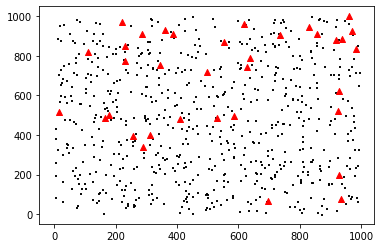

In [288]:
plt.figure(0)
for a in mslist1:
    a.plot()
for a in bslist1:
    a.plot()